## Reading in Data

In [1]:
cd("/home/jzh/Dropbox/Research/Data-driven_estimation_inverse_optimization/Experiments/InverseVIsTraffic");

In [2]:
type Arc
	initNode::Int
	termNode::Int 
    capacity::Float64
    freeflowtime::Float64
    trueflow::Float64
    obsflow::Float64
end

Arc(initNode::Int, termNode::Int, capacity::Float64,freeflowtime::Float64) = 
    Arc(initNode, termNode, capacity, freeflowtime, 0., 0.)

Arc (constructor with 3 methods)

In [4]:
include("./Julia_files/fitTraffic.jl")
using PyPlot

INFO: Loading help data...


In [5]:
#Read in the demand file
file = open("./data_original/SiouxFalls_trips.txt")
demands = Dict{(Int64,Int64), Float64}()
s = 0
for line in eachline(file)
    if contains(line, "Origin")
        s = int(split(line)[2])
    else
        pairs = split(line, ";")
        for pair in pairs
            if !contains(pair, "\n")
                pair_vals = split(pair, ":")
                t, demand = int(pair_vals[1]), float(pair_vals[2])
                demands[(s,t)] = demand
            end
        end
    end
end                
close(file)

In [6]:
arcs = Dict{(Int, Int), Arc}()
#read in the arc files
file = open("./data_original/SiouxFalls_net.txt")
inHeader=true
for line in eachline(file)
    if inHeader
        inHeader = !contains(line, "Init node")
        continue
    end
    vals = split(line, )
    arcs[(int(vals[1]), int(vals[2]))] = Arc(int(vals[1]), int(vals[2]), 
                                              float(vals[3]), float(vals[5]))
end
close(file)

In [7]:
#read in the true costs
file = open("./data_original/SiouxFallsFlow.txt")
ix = 0; test_cost = 0.0
for line in eachline(file)
    ix +=1
    if ix ==1
        continue
    end
    vals = split(line)
    arcs[(int(vals[1]), int(vals[2]))].trueflow = float(vals[3])
    test_cost += float(vals[4])
end
tot_cost = sum(map(a -> bpacost(a.trueflow, a), values(arcs) ))
assert( abs( tot_cost - test_cost) <= 1e-8 ) #note, these costs are not scaled by x!!!

LoadError: BoundsError()
while loading In[7], in expression starting on line 4

## Solving via FW

###Algorithm###
VI condition equivalent to $\min_{x \in \mathcal{F}} F(x)$ for F a potential function.  F is strongly convex...

Approximate $F(x) = F(x^k) + \nabla F(x^k)^T (x - x^k)$.  Approximate minimum by an LP:

$$z^{k+1} \equiv \arg\min_{x \in \mathcal{F}} \nabla F(x^k)^T (x - x^k) = 
\arg\min_{x \in \mathcal{F}} f(x^k)^T x $$

Notice that this problem decouples by odpair.  Each subprobem is a shortest path problem.  Solve as a series of shortest paths.  *Sanity Check: The flows from the shortest path problems should be better than the original flows in this problem*

Do a line search:  $x^{k+1} = x^k + \alpha (z^{k+1} - x^k)$ for $\alpha = \arg \min_{\alpha} F(x^k + \alpha(z^{k+1} - x^k))$.  


In [9]:
#Generate the simulated data
numData = 2 ; sigma = .1
flow_data = Array(Float64, length(arcs), numData)
demand_data = Dict{(Int, Int), Array{Float64, 1}}()

numNodes = maximum(map(pair->pair[1], keys(demands)))
g = simple_inclist(numNodes, is_directed=true)
vArcs = Arc[]
for arc in values(arcs)
    arc.obsflow = arc.trueflow
    add_edge!(g, arc.initNode, arc.termNode) 
    push!(vArcs, arc)
end

# srand(8675309)
# srand(5164174290)
for iRun = 1:numData
    #perturb the demand_data
    for odpair in keys(demands)
        if ! haskey(demand_data, odpair)
            demand_data[odpair] = [demands[odpair] * (1 + sigma * rand()), ]
        else
            push!(demand_data[odpair], demands[odpair] * (1  + sigma * rand()))
        end
    end
    #solve using FW and record
    conv_tol, flow_data[:, iRun] = frank_wolfe(g, vArcs, demand_data, iRun)
    #println(conv_tol)
end

#Just to finish up, go throw and randomzie the flow data a little bit too
for i = 1:size(flow_data, 1)
    for j = 1:size(flow_data, 2)
        flow_data[i, j] *= (1 + sigma * rand() )
    end
end

## Fitting a Single Function

In [18]:
#build a little train function that just takes indices
function train(indices, lam::Float64, deg::Int, c::Float64, 
                demand_data, flow_data, arcs; fcoeffs=nothing)
    numNodes = maximum(map(pair->pair[1], keys(arcs)))
    m, coeffs, reg_term = setUpFitting(deg, c, [k for k=keys(demand_data)], 1:numNodes)
    
    for a in values(arcs)
        a.obsflow = a.trueflow
    end
    addIncreasingCnsts(m, coeffs, arcs, TOL=1e-8)  #uses the original obs flows

    avgCost = mean( [bpacost(a.obsflow, a.capacity, 1.0) for a in values(arcs)] )
    normalize(m, coeffs, [a.obsflow / a.capacity for a in values(arcs)], avgCost)

    # normalize(m, coeffs, 1., bpacost(1., 1., 1.))


    resids = Variable[]
    for i = indices
        #copy the flow data over to the arcs, demand data to demands (slow)
        for (ix, a) in enumerate(vArcs)
            a.obsflow = flow_data[ix, i]
        end
        for odpair in keys(demands)
            demands[odpair] = demand_data[odpair][i]
        end
    
        #Dual Feasibility
        ys = addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
        
        #add the residual for this data point
        push!(resids, addResid(m, coeffs, ys, demands, arcs, 1e6))
    end

    if fcoeffs != nothing
        fixCoeffs(m, fcoeffs, coeffs)
    end
    @setObjective(m, Min, sum{resids[i], i = 1:length(resids)} + lam*reg_term)
    solve(m)
    println(getObjectiveValue(m) - lam * getValue(reg_term) )
    return [getValue(coeffs[i]) for i =1:length(coeffs)]
end

train (generic function with 1 method)

In [22]:
demands

Dict{(Int64,Int64),Float64} with 576 entries:
  (23,8)  => 306.21942090188026
  (8,23)  => 313.3443452684483
  (6,9)   => 408.83280608230245
  (18,3)  => 0.0
  (21,13) => 640.8941339868707
  (22,16) => 1222.4504275228269
  (15,17) => 1542.0404239627921
  (22,14) => 1205.5808523166322
  (13,9)  => 657.0786648987333
  (23,10) => 1817.7322215092468
  (24,22) => 1144.0646825845859
  (8,9)   => 831.0562249913839
  (9,1)   => 521.8210422933589
  (17,14) => 728.6275780832383
  (16,6)  => 958.0245374033776
  (16,12) => 749.3433695969701
  (16,13) => 619.4715206964877
  (22,2)  => 107.99975980878868
  (24,3)  => 0.0
  (7,16)  => 1428.158004368219
  (1,12)  => 208.90188818860116
  (4,5)   => 543.1358738954286
  (11,8)  => 857.4229732712341
  (18,21) => 105.74312751095172
  (19,4)  => 204.54936368278004
  ⋮        => ⋮

In [11]:
#include("trafficCval.jl")

arcs3 = arcs
arcs4 = arcs
arcs5 = arcs
arcs6 = arcs
coeffs_dict = Dict{(Int64,Float64,Float64),Array{Float64,1}}()

# deg = 3
deg = 3
c = 3.41
lam = 1.

fcoeffs3 = train(1:numData, lam, deg, c, demand_data, flow_data, arcs3)
coeffs_dict[(deg, c, lam)] = fcoeffs3

# deg = 4
deg = 4
c = 3.41
lam = 1.

fcoeffs4 = train(1:numData, lam, deg, c, demand_data, flow_data, arcs4)
coeffs_dict[(deg, c, lam)] = fcoeffs4

# deg = 5
deg = 5
c = 2.6
lam = .1

fcoeffs5 = train(1:numData, lam, deg, c, demand_data, flow_data, arcs5)
coeffs_dict[(deg, c, lam)] = fcoeffs5

# deg = 6
deg = 6
c = 2.6
lam = 1e-3

fcoeffs6 = train(1:numData, lam, deg, c, demand_data, flow_data, arcs6)
coeffs_dict[(deg, c, lam)] = fcoeffs6

0.5482149058315559
0.4834770597429161
0.32089966550921273
0.24522767164292958


7-element Array{Float64,1}:
   1.0     
   1.56966 
 -11.783   
  17.6641  
 -11.4595  
   3.45055 
  -0.393502

In [12]:
keys(coeffs_dict)

KeyIterator for a Dict{(Int64,Float64,Float64),Array{Float64,1}} with 4 entries. Keys:
  (6,2.6,0.001)
  (3,3.41,1.0)
  (5,2.6,0.1)
  (4,3.41,1.0)

In [11]:
#try this out for a second
using Resampling, DataFrames
df = DataFrame()
df["A"] = 1:numData
train(df) = train(df["A"], 1., 3, 3.41, demand_data, flow_data, arcs)
test(df, fit) = test(fit, df["A"], demand_data, flow_data, arcs, g, vArcs)
rtrain, rtest = kfold_crossvalidate(df, train, test, 5)


LoadError: `setindex!` has no method matching setindex!(::DataFrame, ::UnitRange{Int64}, ::ASCIIString)
while loading In[11], in expression starting on line 4

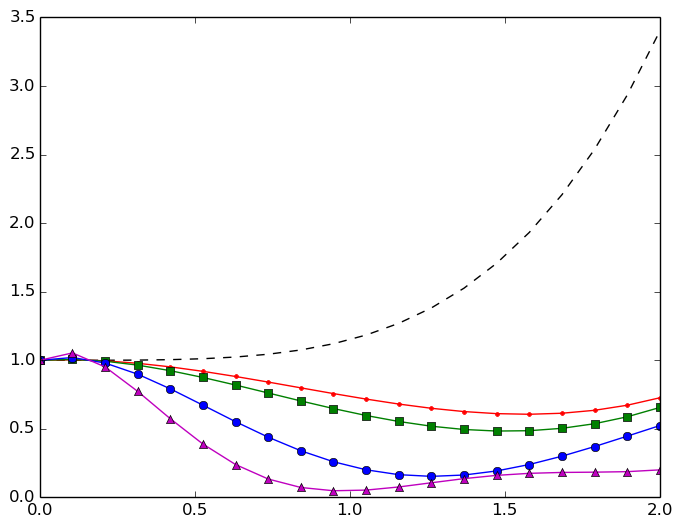

In [13]:
true_coeffs = [1, 0, 0, 0, .15]
fcoeffs3 = coeffs_dict[(3, 3.41, 1.)]
fcoeffs4 = coeffs_dict[(4, 3.41, 1.)]
fcoeffs5 = coeffs_dict[(5, 2.6, .1)]
fcoeffs6 = coeffs_dict[(6, 2.6, 1e-3)]

xs = linspace(0, 2, 20)
ys_true = map(x->polyEval(true_coeffs, x), xs)
ys3 = map(x->polyEval(fcoeffs3, x), xs)
ys4 = map(x->polyEval(fcoeffs4, x), xs)
ys5 = map(x->polyEval(fcoeffs5, x), xs)
ys6 = map(x->polyEval(fcoeffs6, x), xs)

# ys = map(x->polyEval(fcoeffs, x), xs)

plot(xs, ys_true, "--k")
plot(xs, ys3, ".-r")
plot(xs, ys4, "s-g")
plot(xs, ys5, "o-b")
plot(xs, ys6, "^-m")

# plot(xs, ys, "--b")

ylim(0, 3.5);

In [112]:
df = DataFrame([xs ys_true ys3 ys4 ys5 ys6])
colnames!(df, ["Flow"; "True"; "Deg3"; "Deg4"; "Deg5"; "Deg6"])
writetable("fittedFuncs.csv", df)

LoadError: hcat: mismatched dimensions
at In[112]:1

In [69]:
fcoeffs = fcoeffs3


4-element Array{Float64,1}:
  1.19177 
  0.210887
 -0.55088 
  0.477951

## Out of Sample Residuals

In [13]:
#Generate some out of sample data
#Generate the simulated data
numDataOut = 500
oflow_data = Array(Float64, length(arcs), numDataOut)
odemand_data = Dict{(Int, Int), Array{Float64, 1}}()

srand(5167462266)
for iRun = 1:numDataOut
    #perturb the demand_data
    for odpair in keys(demands)
        if ! haskey(odemand_data, odpair)
            odemand_data[odpair] = [demands[odpair] * (1 + sigma * rand()), ]
        else
            push!(odemand_data[odpair], demands[odpair] * (1  + sigma * rand()))
        end
    end
    #solve using FW and record
    conv_tol, oflow_data[:, iRun] = frank_wolfe(g, vArcs, odemand_data, iRun)
end

#Just to finish up, go throw and randomzie the flow data a little bit too
for i = 1:size(oflow_data, 1)
    for j = 1:size(oflow_data, 2)
        oflow_data[i, j] *= (1 + sigma * rand() )
    end
end

In [23]:
#Calculate the residuals on the out of sample data
oResids = Float64[] ; oResidsTrue = Float64[];  oResidsRel = Float64[]
true_coeffs = [1, 0, 0, 0, .15]
for i = 1:numDataOut
    push!(oResids, test(fcoeffs, i, odemand_data, oflow_data, arcs, g, vArcs))
    push!(oResidsTrue, test(true_coeffs, i, odemand_data, oflow_data, arcs, g, vArcs))
    push!(oResidsRel, test(fcoeffs, i, odemand_data, oflow_data, arcs, g, vArcs, relative=true))
end    

df = DataFrame([ oResids oResidsTrue oResidsRel ])
colnames!(df, ["Resids"; "ResidsTrue"; "ResidsRel"])
writetable("resids.csv", df)


In [16]:
using DataFrames

0.7072749186588113  0.055027370134098655
0.06573006922456988  0.004653405241423066


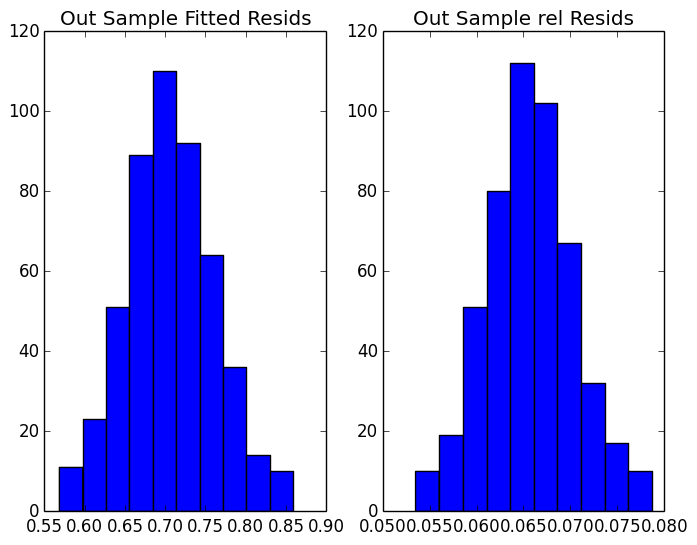

In [24]:
#Compute histograms of the fitted function and the true function
subplot(1, 2, 1)
plt.hist(oResids * 1e-6)
plt.title("Out Sample Fitted Resids")

subplot(1, 2, 2)
plt.hist(oResidsRel)
plt.title("Out Sample rel Resids")

println(mean(oResids) * 1e-6, "  ", std(oResids)*1e-6 )
println(mean(oResidsRel), "  ", std(oResidsRel))


### Generalization Error 

In [25]:
# observed generalization error
zN = 0.8146719163729105
Hnorm = sqrt(0.609463046750461)
R  = 3  ## Guesstimated
beta = .1
Kbar = sqrt((c + R^2)^deg);
Bbar = 2 * R * Kbar * Hnorm * 1e-6
R_N = (4 * Bbar + 2 * sqrt(Bbar) * sqrt(2 * log(2/beta) ) ) / sqrt(numData)

# Cross Val Error  #pulled from table in R
cv_mean = 1e-6 * mean(rtest); cv_std = 1e-6 * std(rtest)

alpha = .1
#Compute 90% quantiles for each
println("Pred Bound:\t $(zN + R_N / alpha)")
println("CV Bound:\t $(cv_mean + sqrt(1/alpha - 1) * cv_std)")
println("OutSample:\t $(quantile(oResids * 1e-6, 1-alpha))")
R_N

Pred Bound:	 0.97315076282393
CV Bound:	 0.6241991890484572
OutSample:	 0.7781879713046712


0.015847884645101947

In [56]:
println(cv_mean, "  ", cv_std)
println(mean(oResids), "  ", std(oResids) )

0.7129017842709476  0.04093004657736838
822794.3172721053  62516.29681303994
0.9019244268535506
0.900937275725576
0.8905734683559084
0.8958335921638096
0.9090999287266431


### Difference To Flows

In [26]:
oFlowDiffs = Array(Float64, numDataOut, 2)
temp_flow = Array(Float64, size(oflow_data, 1))
for iRun = 1:numDataOut
    #solve for the flows with the fitted function
    conv_tol, temp_flow = frank_wolfe(g, vArcs, odemand_data, iRun)
    oFlowDiffs[iRun, 1] = norm(temp_flow - oflow_data[:, iRun])
    oFlowDiffs[iRun, 2] = norm(temp_flow - oflow_data[:, iRun]) / norm(oflow_data[:, iRun])
end


In [27]:
t = DataFrame(oFlowDiffs)
colnames!(t, ["Abs", "Rel"])
writetable("FlowDiffs.csv", t)

size(oFlowDiffs)

(500,2)

In [28]:
mean(oFlowDiffs, 1)

1x2 Array{Float64,2}:
 7075.05  0.0550048

### Ambiguity Sets

In [50]:
zN, zN + 2e6 * cv_std

(0.8146719163729105,14195.29710723033)

In [46]:
xs = linspace(0, 2, 30)
bounds[:, 3] = calcBound(1:numData, deg, c,  zN + 2*cv_std, demand_data, flow_data, arcs, :Min, xs,  ball_radius=Hnorm)
#                         (indices, deg::Int, c::Float64, target_val, 
#     demand_data, flow_data, arcs, SENSE, xs; ball_radius=nothing)

bounds[:, 4] = calcBound(1:numData, deg, c,  zN + 2*cv_std, demand_data, flow_data, arcs, :Max, xs, ball_radius=Hnorm)

Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal


30-element Array{Float64,1}:
 2.28954
 2.28954
 2.28954
 2.28954
 2.28954
 2.28955
 2.28954
 2.28954
 2.28954
 2.28954
 2.28954
 2.28954
 2.28954
 ⋮      
 2.38011
 2.40956
 2.44725
 2.5051 
 2.56856
 2.6259 
 2.75244
 2.89901
 3.0473 
 3.29961
 3.73759
 4.20984

In [45]:
bounds = Array(Float64, 30, 4);
xs = linspace(0, 2, 30)
for j = 1:30
    bounds[j, 1] = bpacost(xs[j], 1., 1.)
    bounds[j, 2] = polyEval(fcoeffs, xs[j])
end    


In [47]:
bounds[1:10, :]

10x4 Array{Float64,2}:
 1.0      1.19013  -0.731883     2.28954
 1.0      1.19966  -0.475851     2.28954
 1.00005  1.20553  -0.231676     2.28954
 1.00027  1.20861   0.00377095   2.28954
 1.00087  1.20981  -0.000286405  2.28954
 1.00212  1.21002   0.000254485  2.28955
 1.0044   1.21011   0.00328736   2.28954
 1.00815  1.21099   0.0107168    2.28954
 1.0139   1.21355   0.022816     2.28954
 1.02226  1.21867   0.0422392    2.28954

In [31]:
function calcBound(indices, deg::Int, c::Float64, target_val, 
    demand_data, flow_data, arcs, SENSE, xs; ball_radius=nothing)

    numNodes = maximum(map(pair->pair[1], keys(arcs)))
    m, coeffs, reg_term = setUpFitting(deg, c, [k for k=keys(demand_data)], 1:numNodes)
    
    for a in values(arcs)
        a.obsflow = a.trueflow
    end
    addIncreasingCnsts(m, coeffs, arcs, TOL=1e-8)  #uses the original obs flows
    
    #Compute the total cost on the network and the avg bpacost
    avgCost = mean( [bpacost(a.obsflow, a.capacity, 1.0) for a in values(arcs)] )    
    normalize(m, coeffs, [a.obsflow / a.capacity for a in values(arcs)], avgCost)
    
    resids = Variable[]
    for i = indices
        #copy the flow data over to the arcs, demand data to demands (slow)
        for (ix, a) in enumerate(vArcs)
            a.obsflow = flow_data[ix, i]
        end
        for odpair in keys(demands)
            demands[odpair] = demand_data[odpair][i]
        end
    
        #Dual Feasibility
        ys = addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
        
        #add the residual for this data point
        push!(resids, addResid(m, coeffs, ys, demands, arcs, 1e6))
    end

    @addConstraint(m, sum{resids[i], i=1:length(resids)} / length(resids) <= target_val * 1e6)
    if ball_radius != nothing
        @addConstraint(m, reg_term <= ball_radius^2 )
    end
    
    bounds = Array(Float64, length(xs))
    
    for (j, x) in enumerate(xs)
        setObjective(m, SENSE, polyEval(coeffs, x))
        println(solve(m))
        bounds[j] = getObjectiveValue(m)
    end
    return bounds
end


calcBound (generic function with 1 method)

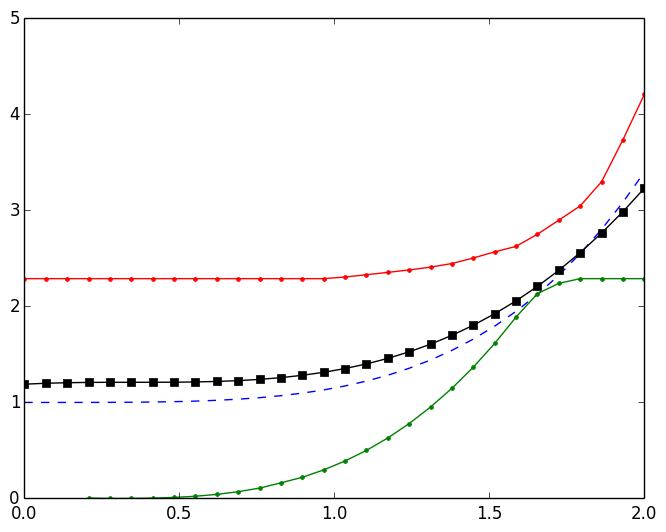

(0,5)

In [48]:
plot(xs, bounds[:, 1], "--")
plot(xs, bounds[:, 2], "s-k")
plot(xs, bounds[:, 3], ".-")
plot(xs, bounds[:, 4], ".-")
plt.ylim(0, 5)


In [49]:
df = DataFrame([xs bounds])
colnames!(df, ["Flows"; "True"; "Fit"; "LB"; "UB"])
writetable("amgSetsTraffic.csv", df)

## Cross-Validate Code

In [10]:
using DataFrames, Resampling

In [8]:
#build a little train function that just takes indices
function train(indices, lam::Float64, deg::Int, c::Float64, 
                demand_data, flow_data, arcs)
    numNodes = maximum(map(pair->pair[1], keys(arcs)))
    m, coeffs, reg_term = setUpFitting(deg, c, [k for k=keys(demand_data)], 1:numNodes)
    
    for a in values(arcs)
        a.obsflow = a.trueflow
    end
    addIncreasingCnsts(m, coeffs, arcs, TOL=1e-8)  #uses the original obs flows
    
    #Compute the total cost on the network and the avg bpacost
    avgCost = mean( [bpacost(a.obsflow, a.capacity, 1.0) for a in values(arcs)] )    
    normalize(m, coeffs, [a.obsflow / a.capacity for a in values(arcs)], avgCost)
    
    resids = Variable[]
    for i = indices
        #copy the flow data over to the arcs, demand data to demands (slow)
        for (ix, a) in enumerate(vArcs)
            a.obsflow = flow_data[ix, i]
        end
        for odpair in keys(demands)
            demands[odpair] = demand_data[odpair][i]
        end
    
        #Dual Feasibility
        ys = addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
        
        #add the residual for this data point
        push!(resids, addResid(m, coeffs, ys, demands, arcs, 1e6))
    end

    @setObjective(m, Min, sum{resids[i], i = 1:length(resids)} + lam*reg_term)
    solve(m)
    println((getObjectiveValue(m) - lam * getValue(reg_term))/ length(resids), "  ", getValue(reg_term) )
    return [getValue(coeffs[i]) for i =1:length(coeffs)]
end


train (generic function with 1 method)

In [20]:
df = DataFrame()
df["A"] = 1:numData

lamb_grid = [10. .^(-6:1)]
c_grid = -5.:.5:5
deg_grid = [2:6]

lamb_grid = [10. .^-6, ]
c_grid = 1.
deg_grid = 6

N = length(lamb_grid) * length(c_grid) * length(deg_grid)

res = Array(Float64, N, 5)
ix = 1
for l in lamb_grid
    for c in c_grid
        for d in deg_grid
            train(df) = train(df["A"], l, d, c, demand_data, flow_data, arcs)
            test(df, fit) = test(fit, df["A"], demand_data, flow_data, arcs, g, vArcs)
            rtrain, rtest = kfold_crossvalidate(df, train, test, 2)
            
            res[ix, 1] = l
            res[ix, 2] = c
            res[ix, 3] = float(d)
            res[ix, 4] = mean(rtest) / 1e6
            res[ix, 5] = std(rtest) / 1e6

            ix +=1
        end
    end
end

1.8989195397910659
1.8744766393114214


In [22]:
writetable("trafficCVal.csv", DataFrame(res))